In [483]:
FOLDER = 'resources/'
PRINT = True

In [484]:
%run html_export.py
%run common.py
%matplotlib inline

Planning start time: Jul 27, 16:31 (1469626302)


In [485]:
# Убираем локомотивы с маленьким пробегом
MIN_LOCO_DIST = 50 # (километров)

# Убираем локомотивы, которые стояли без работы довольно большое время в конце суток
NW_HORIZON = 12 * 3600 # (часов)

## Производительность и пробег локомотивов

### Формула для расчета

Производительность локомотивов (ПЛ) показывает величину полезного использования локомотивов. Если локомотивы часто везут поезда и мало простаивают на станциях, то производительность будет высокой. Если локомотивы часто пересылаются резервом и много простаивают, то производительность будет низкой.

ПЛ считается по формуле: $$W=\sum_i \frac{Q_i L_i}{N}$$, где $Q_i$ - вес поезда, с которым следует локомотив, $L_i$ - длина маршрута поезда, где к поезду прикреплен локомотив, $N$ - количество всех локомотивов, используемых в планировании. Суммирование ведется по всем запланированным поездам, к которым подвязаны локомотивы, без учета поездов, которые представляют из себя локомотивы резервом. В суммировании присутствуют только поезда, запланированные на горизонте в 1 сутки от начала планирования. Маршрут поезда также обрезается на суточном горизонте: остаются только те участки, которые поезд успеет проехать за первые сутки от начала планирования.

**Средний пробег локомотивов** считается по очень похожей формуле: $$D=\sum_i \frac{L_i}{N}$$ Поскольку с весами поездов проблем нет, то для пробега локомотивов будут применимы все те же рассуждения, что и для производительности.

In [486]:
# Маска для выделения локомотивов только внутри суток

horizon = 24 * 3600
mask = (loco_plan.time_start < current_time + horizon) & (loco_plan.time_end >= current_time)

In [487]:
loco_plan['travel_time'] = loco_plan.time_end - loco_plan.time_start
loco_plan['dist'] = loco_plan.link.map(links.set_index('link').dist)

# Если движение локомотива пришлось на границу суточного интервала, то пропорционально обрезаем travel_time и dist

loco_plan['before_ct'] = current_time - loco_plan.time_start
loco_plan['after_ct_hor'] = loco_plan.time_end - (current_time + horizon)
loco_plan['tt_hor'] = loco_plan.travel_time
loco_plan['dist_hor'] = loco_plan.dist
loco_plan.loc[mask & (loco_plan.before_ct > 0), 'tt_hor'] = loco_plan.travel_time - loco_plan.before_ct
loco_plan.loc[mask & (loco_plan.before_ct > 0), 'dist_hor'] = np.round((loco_plan.tt_hor/loco_plan.travel_time) *\
                                                                       loco_plan.dist)
loco_plan.loc[mask & (loco_plan.after_ct_hor > 0), 'tt_hor'] = loco_plan.travel_time - loco_plan.after_ct_hor
loco_plan.loc[mask & (loco_plan.after_ct_hor > 0), 'dist_hor'] = np.round((loco_plan.tt_hor/loco_plan.travel_time) *\
                                                                          loco_plan.dist)

In [488]:
# Добавляем в таблицу локомотивов вес поезда для расчета производительности

def to_map(df, col):
    return df.drop_duplicates(col).set_index(col)
    
av_weight = round(train_info.weight.mean())
train_plan['fake_weight'] = train_plan.train.apply(lambda x: 0 if str(x)[0] == '8' else av_weight)
train_plan.weight.fillna(train_plan.fake_weight, inplace=True)
loco_plan['weight'] = loco_plan.train.map(to_map(train_plan, 'train').weight)

loco_plan['PL'] = (loco_plan.weight * loco_plan.dist_hor) / 1000
lp_day = loco_plan[mask & loco_plan.state.isin([0, 1])].copy()
PL = lp_day.groupby('loco').PL.sum()

In [489]:
print('Настоящая производительность: %.2f тонн*км' % (PL.sum() / PL.count()))

Настоящая производительность: 1436.92 тонн*км


### Что влияет на ПЛ

1. **Локомотивы резервом**. Большое количество пересылок локомотивов резервом приводит к тому, что у локомотива увеличивается пробег, но в ПЛ такие пересылки вносят нулевой вклад (из-за того, что вес таких поездов = 0).
2. **Вывозные локомотивы**. Вывозные локомотивы работают мало и на небольших участках. Для таких поездо-локомотивов длина пройденного маршрута будет маленькой, а значит, их вклад в числитель дроби тоже будет маленьким. Эти локомотивы будут существенно занижать ПЛ.
3. **Локомотивы, стоящие долгое время без работы**. Локомотивы, которые на момент начала планирования находятся в работе, а затем становятся не нужны для планирования. Такое может быть, если планировщик для вывоза поездов обходится меньшим количством локомотивов, нежели ему было передано. Тогда для таких локомотивов длина пройденного маршрута тоже будет мала, ПЛ будет падать. Такие локомотивы можно не учитывать при подсчете ПЛ, если предположить, что эти локомотивы будут отставлены в резерв ЦД.

In [490]:
def nice_count(df, col):
    return df.drop_duplicates(col)[col].count()

to_plot = {}

lp_day_res = loco_plan[mask & loco_plan.state.isin([0])]
lp_day_work = loco_plan[mask & loco_plan.state.isin([1])]
PL_work = lp_day_work.groupby('loco').PL.sum()
to_plot['Без резервов'] = lp_day_work

print('Всего %d локомотивов (%.2f%%) пересылаются резервом хотя бы один раз' 
      % (nice_count(lp_day_res, 'loco'), 100 * nice_count(lp_day_res, 'loco') / nice_count(lp_day, 'loco')))
print('%.2f%% от полного пробега всех локомотивов составляют поездки резервом' 
      % (100 * lp_day_res.dist_hor.sum() / lp_day.dist_hor.sum()))

a = lp_day.groupby('loco').dist_hor.sum()
long_locos = a[a > MIN_LOCO_DIST].index
lp_long = lp_day[lp_day.loco.isin(long_locos)]
PL_long = lp_long.groupby('loco').PL.sum()
to_plot['Без коротких'] = lp_long
print('\nВсего %d (%.2f%%) локомотивов с коротким (меньше 50 км.) пробегом'
     % ((nice_count(lp_day, 'loco') - len(long_locos)), 100 * (1 - len(long_locos) / nice_count(lp_day, 'loco'))))

a = lp_day.groupby('loco').time_end.max()
loco_cd = a[a < current_time + NW_HORIZON]
lp_no_cd = lp_day[lp_day.loco.isin(loco_cd.index) == False]
PL_cd = lp_no_cd.groupby('loco').PL.sum()
to_plot['Без отставленных в резерв'] = lp_no_cd
print('\nВсего %d (%.2f%%) локомотивов, которые завершили работу за 12 часов до конца суток'
     % (loco_cd.count(), 100* loco_cd.count() / nice_count(lp_day, 'loco')))

Всего 861 локомотивов (54.95%) пересылаются резервом хотя бы один раз
31.54% от полного пробега всех локомотивов составляют поездки резервом

Всего 28 (1.79%) локомотивов с коротким (меньше 50 км.) пробегом

Всего 117 (7.47%) локомотивов, которые завершили работу за 12 часов до конца суток


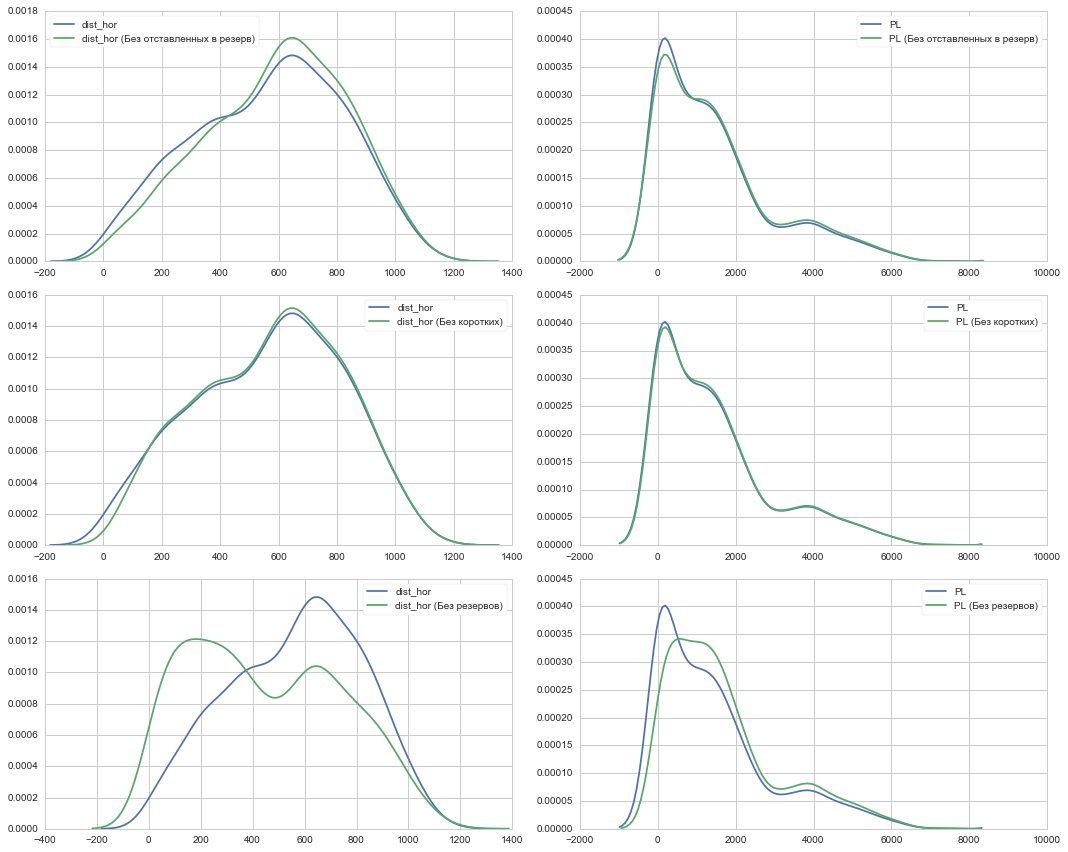

In [491]:
sns.set(style='whitegrid', context='notebook')
nrows, ncols = 3, 2
plt.subplots(nrows, ncols, figsize=(7.5*ncols, 4*nrows))
cnt = 0
keys = list(to_plot.keys())
for i in range(nrows):
    k = keys[i]    
    for j in range(ncols):        
        col = 'dist_hor' if (2*i+j)%2 == 0 else 'PL'
        plt.subplot(nrows, ncols, 2*i+j+1)
        sns.kdeplot(lp_day.groupby('loco')[col].sum(), label=col)
        sns.kdeplot(to_plot[k].groupby('loco')[col].sum(), label='%s (%s)' % (col, k))
        plt.legend(frameon=True, loc='best')
        
plt.tight_layout()


In [492]:
print('Производительность только для работающих локомотивов: %.2f тонн*км' % (PL_work.sum() / PL_work.count()))
print('Производительность только для "длинных" локомотивов: %.2f тонн*км' % (PL_long.sum() / PL_long.count()))
print('Производительность только для локомотивов, не отставленных в резерв: %.2f тонн*км' % (PL_cd.sum() / PL_cd.count()))

Производительность только для работающих локомотивов: 1677.84 тонн*км
Производительность только для "длинных" локомотивов: 1462.51 тонн*км
Производительность только для локомотивов, не отставленных в резерв: 1503.72 тонн*км


Также на ПЛ может влиять малое количество запланированных поездов или сдвиг поездов на большое время в будущее.

Проверим, сколько фейковых поездов своего формирования на самом деле было запланировано в сутки, и сравним с заданным количеством.

In [493]:
task = pd.read_csv(FOLDER + 'task.csv', dtype={'st_from':str, 'st_to':str})
from datetime import datetime as dt
next_dt = (dt.fromtimestamp(current_time) + datetime.timedelta(0, (6+18)*3600, 0))
ts = int(dt(next_dt.year, next_dt.month, next_dt.day, 18, 0, 0).timestamp())
ttn = task[task.time_end <= ts].drop_duplicates(['id', 'time_start']).number.sum()
train_plan['train_type'] = train_plan.train.apply(lambda x: int(str(x)[0]))
tpn = train_plan[(train_plan.time_start < current_time + 24 * 3600)
          & (train_plan.train_type == 9)].drop_duplicates('train').train.count()

print('Всего запланировано %d фейковых поездов, передано в заданиях - %d' % (tpn, ttn))

Всего запланировано 510 фейковых поездов, передано в заданиях - 978


In [494]:
print('Средний пробег фейкового поезда за сутки: %.2f км.' 
      % (lp_day[lp_day.train.isin(train_plan[(train_plan.time_start < current_time + 24 * 3600)
          & (train_plan.train_type == 9)].train)].dist_hor.sum() / tpn))

Средний пробег фейкового поезда за сутки: 151.08 км.


Можно грубо рассчитать средний ожидаемый пробег для фейковых поездов за сутки. Пусть средний маршрут одного поезда имеет длину $d_A$ и время хода $t_A$ (если принять среднюю скорость поезда за 45 км/ч, то $d_A = 45t_A$). Если поезд будет отправлен ранее, чем за время $t_A$ от конца суток, то он успеет пройти все расстояние $d_A$ в сутки. Если поезд будет отправлен позже, то он успеет пройти меньшее расстояние. Можно легко показать, что средняя длина маршрута поезда будет $$d = d_A\left(1-\frac{t_A}{48}\right)$$

Если принять $t_A = 12$ и $d_A = 12\cdot45 = 540$, то получим $d = 405$.

Видно, что существуют две проблемы: 
* средний пробег фейковых поездов меньше ожидаемого (примерно в 3 раза);
* количество запланированных фейковых поездов меньше ожидаемого (примерно в 2 раза).

Причины: откладывание отправления поездов из-за плохого алгоритма поиска локомотивов.

Вариант решения: умножать пробеги имеющихся фейковых поездов на $2\cdot3=6$.

In [495]:
lp_day['fake_dist_hor'] = lp_day.apply(lambda row: row.dist_hor * 6.0 if str(row.train)[0] == '9' else row.dist_hor, axis=1)
lp_day['fake_PL'] = lp_day.fake_dist_hor * lp_day.weight / 1000
PL_fake = lp_day.groupby('loco').fake_PL.sum()
print('Производительность локомотивов с учетом коэффициента на пробег поездов: %.2f тонн*км' % (PL_fake.sum() / PL_fake.count()))

Производительность локомотивов с учетом коэффициента на пробег поездов: 2300.87 тонн*км


### Выводы

1. На производительность сильно влияет количество поездов. Главная проблема в том, что на суточном горизонте планируется очень мало фейковых поездов и эти поезда сдвинуты в конец суток. Если ввести поправочный коэффициент, который учитывает эти погрешности в планировании, то значение производительности локомотивов становится правильным.
2. Множественная пересылка локомотивов резервом тоже влияет на ПЛ, но слабее. Слабое влияние объясняется тем, что пересылаемые резервом локомотивы все же везут поезда и мало простаивают.
3. Остальные эвристики (виртуальная отставка локомотивов в резерв ЦД, фильтрация локомотивов с очень короткими маршрутами) практически не вносит улучшений в ПЛ.

## Эвристики для улучшения производительности локомотивов

In [496]:
# Убираем локомотивы с маленьким пробегом
min_loco_dist = 50 # (километров)

# Убираем локомотивы, которые стояли без работы довольно большое время в конце суток
nw_horizon = 12 * 3600 # (часов)

# Коэффициет увеличения длины маршрута для поездов своего формирования из заданий ССП
dist_coef = 1.0

# Средний вес, который задается для поездов из заданий ССП и ПРОГРЕСС
av_weight = 3500

In [497]:
# add_header('Эвристики', h=2, p=False)
# add_line('Убираем локомотивы с пробегом меньше %d км.' % min_loco_dist)
# add_line('Убираем локомотивы, которые стояли без работы больше %d часов в конце суток' % (nw_horizon / 3600))
# add_line('Коэффициент увеличения длины маршрута для поездов своего формирования из заданий ССП: %.2f' % dist_coef)
# add_line('Средний вес поезда, который задается для поездов из заданий ССП и ПРОГРЕСС: %d' % av_weight)

#### Маска для выделения локомотивов только внутри суток

In [498]:
# Маска для выделения локомотивов только внутри суток

horizon = 24 * 3600
mask = (loco_plan.time_start < current_time + horizon) & (loco_plan.time_end >= current_time)

## Добавление времени хода и длины участка в таблицу локомотивных планов

In [499]:
# Добавляем в таблицу loco_plan атрибуты travel_time и dist

loco_plan['travel_time'] = loco_plan.time_end - loco_plan.time_start
loco_plan['dist'] = loco_plan.link.map(links.set_index('link').dist)

# Если движение локомотива пришлось на границу суточного интервала, то пропорционально обрезаем travel_time и dist

loco_plan['before_ct'] = current_time - loco_plan.time_start
loco_plan['after_ct_hor'] = loco_plan.time_end - (current_time + horizon)
loco_plan['tt_hor'] = loco_plan.travel_time
loco_plan['dist_hor'] = loco_plan.dist
loco_plan.loc[mask & (loco_plan.before_ct > 0), 'tt_hor'] = loco_plan.travel_time - loco_plan.before_ct
loco_plan.loc[mask & (loco_plan.before_ct > 0), 'dist_hor'] = np.round((loco_plan.tt_hor/loco_plan.travel_time) *\
                                                                       loco_plan.dist)
loco_plan.loc[mask & (loco_plan.after_ct_hor > 0), 'tt_hor'] = loco_plan.travel_time - loco_plan.after_ct_hor
loco_plan.loc[mask & (loco_plan.after_ct_hor > 0), 'dist_hor'] = np.round((loco_plan.tt_hor/loco_plan.travel_time) *\
                                                                          loco_plan.dist)

## Добавление атрибутов для расчета производительности в локопланы

In [500]:
# Добавляем в таблицу локомотивов атрибуты поезда для расчета производительности

train_info.loc[train_info.weight == 0, 'weight'] = 3500
loco_plan['train_weight'] = loco_plan.train.map(train_info.drop_duplicates(subset=['train']).set_index('train').weight)
loco_plan['train_type'] = loco_plan.train.apply(lambda x: str(x)[:1])
loco_plan['road'] = loco_plan.link.map(links.set_index('link').road)
loco_plan.loc[loco_plan.train == '-1', 'train_weight'] = 0
loco_plan.loc[loco_plan.train_type == '8', 'train_weight'] = 0
loco_plan.loc[loco_plan.train_type == '9', 'train_weight'] = av_weight

#print(loco_plan.train_weight.value_counts())
train_plan['dist'] = train_plan.link.map(links.set_index('link').dist)
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
day_dist = train_plan.loc[train_plan.train_type == '9'].groupby('train').dist.sum()
short = day_dist[day_dist < 500]
loco_plan.loc[loco_plan.train.isin(short.index), 'dist_hor'] = \
                    loco_plan.loc[loco_plan.train.isin(short.index), 'dist_hor'] * dist_coef

#loco_plan.loc[loco_plan.train_type == '9', 'dist_hor'] = loco_plan.loc[loco_plan.train_type == '9', 'dist_hor'] * dist_coef
loco_plan['product'] = loco_plan.dist_hor * loco_plan.train_weight / 1000
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
# add_line('Средний вес реального поезда: %.2f' % (train_plan.loc[(train_plan.time_start >= current_time) 
#                                                     & (train_plan.time_start < current_time + horizon) 
#                                                     & (train_plan.train_type == '2')].drop_duplicates('train').weight.mean()))

## Анализ исходных данных по количеству локомотивов и суточному пробегу

In [501]:
add_header('Анализ результатов планирования по количеству локомотивов и суточному пробегу', h=2, p=False)

#### Расчет количества запланированных локомотивов

In [502]:
total_n = len(loco_plan[loco_plan.state.isin([0, 1])].loco.drop_duplicates().index)
total_hor = loco_plan[mask & (loco_plan.state.isin([0, 1]))].copy(deep=True)
total_hor_n = len(loco_plan[mask & (loco_plan.state.isin([0, 1]))].loco.drop_duplicates().index)
total_work_hor = loco_plan[mask & (loco_plan.state == 1)].copy(deep=True)
total_work_hor_n = len(total_work_hor.loco.drop_duplicates().index)
# add_line('Всего запланировано локомотивов: %d' % total_n)
# add_line('---- в том числе в первые сутки: %d (%.2f%%)' % (total_hor_n, 100 * total_hor_n / total_n))
# add_line('---- в том числе в первые сутки в работе с поездом: %d (%.2f%%)' 
#        % (total_work_hor_n, 100 * total_work_hor_n / total_n))

#### Анализ суточного пробега локомотивов

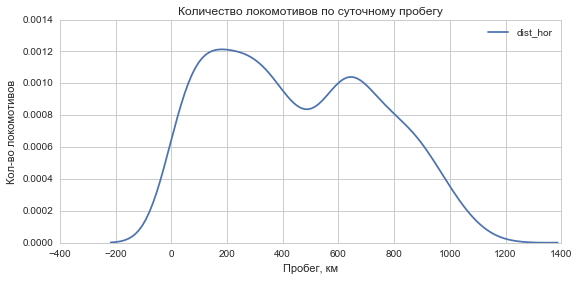

In [503]:
sns.set(style='whitegrid', context='notebook')
fig = plt.figure(figsize=(8, 4))
sns.kdeplot(total_work_hor.groupby('loco').dist_hor.sum())
plt.title('Количество локомотивов по суточному пробегу')
plt.xlabel('Пробег, км')
plt.ylabel('Кол-во локомотивов')
filename = FOLDER + 'loco_dist.png'
plt.savefig(filename, bbox_inches='tight')
add_image(filename)

## Применение эвристик

#### Убираем локомотивы, которые не работали последние 12 часов суток

In [504]:
loco_plan['is_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
loco_plan['nwt'] = 0
loco_plan.loc[loco_plan.is_end == True, 'nwt'] = current_time + horizon - loco_plan.time_end
no_expl = loco_plan.loc[loco_plan.nwt > nw_horizon, ['loco', 'time_end', 'nwt']]
total_work_hor_expl = total_work_hor[total_work_hor.loco.isin(no_expl.loco) == False]
total_work_hor_expl_n = len(total_work_hor_expl.loco.drop_duplicates().index)

#### Убираем локомотивы с пробегом меньше 50 км

In [505]:
loco_dist = total_work_hor_expl.groupby('loco').dist_hor.sum()
df_loco_dist = loco_dist.to_frame()
df_loco_dist_long = df_loco_dist.loc[df_loco_dist.dist_hor > min_loco_dist]
total_work_hor_expl_long = total_work_hor_expl[total_work_hor_expl.loco.isin(df_loco_dist_long.index)]
total_work_hor_expl_long_n = len(total_work_hor_expl_long.loco.drop_duplicates().index)
print('Осталось локомотивов:', total_work_hor_expl_long_n)

Осталось локомотивов: 1197


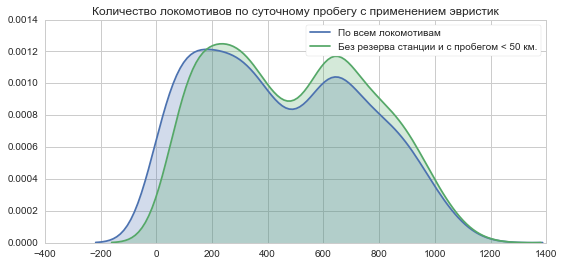

In [506]:
fig = plt.figure(figsize=(8, 4))
sns.kdeplot(total_work_hor.groupby('loco').dist_hor.sum(), label= 'По всем локомотивам', shade=True)
sns.kdeplot(total_work_hor_expl_long.groupby('loco').dist_hor.sum(), 
            label='Без резерва станции и с пробегом < 50 км.', shade=True)
plt.legend(frameon=True)
plt.title('Количество локомотивов по суточному пробегу с применением эвристик')
filename = FOLDER + 'loco_dist_evr.png'
plt.savefig(filename, bbox_inches='tight')
add_image(filename)

#### Считаем процент времени, который локомотив находился на той или иной дороге

In [507]:
#cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'road', 'state', 'road_start', 'road_end']
total_hor = total_hor.dropna(subset=['road'])
total_hor['road_start'] = (total_hor.road != total_hor.road.shift(1)) |\
                                (total_hor.loco != total_hor.loco.shift(1))
total_hor['road_end'] = (total_hor.road != total_hor.road.shift(-1)) |\
                                (total_hor.loco != total_hor.loco.shift(-1))
start_road = total_hor.loc[(total_hor.road_start == True)]
end_road = total_hor.loc[(total_hor.road_end == True)]
a = start_road[['loco', 'st_from_name', 'time_start', 'road']].reset_index()               
b = end_road[['st_to_name', 'time_end']].reset_index()
road_percent = pd.concat([a, b], axis = 1)
c = road_percent.groupby('loco').time_start.min().reset_index()
d = road_percent.groupby('loco').time_end.max().reset_index()
c['ts'] = current_time
d['te'] = current_time + horizon
road_percent = road_percent.set_index(['loco', 'time_start']).join(c.set_index(['loco', 'time_start'])).reset_index()
road_percent = road_percent.set_index(['loco', 'time_end']).join(d.set_index(['loco', 'time_end'])).reset_index()
road_percent.loc[(road_percent.ts.isnull() == False), ['time_start']] = road_percent.ts
road_percent.loc[(road_percent.te.isnull() == False), ['time_end']] = road_percent.te
road_percent['tt'] = road_percent.time_end - road_percent.time_start
road_percent['road_percent'] = np.round(road_percent.tt / 86400, 4)
# add_header('Участки работ локомотивов по дорогам и проценты работы на каждой дороге (показаны первые 10 локомотивов):')
# add_line(road_percent[['loco', 'time_start', 'time_end', 'st_from_name', 'st_to_name', 'road', 'road_percent']].head(10))

#### Добавляем проценты времени в таблицы с локомотивными планами

In [508]:
def add_road_percent(df):
    if 'road_percent' not in df.columns:
        a = road_percent.groupby(['loco', 'road']).road_percent.sum()
        a.name = 'road_percent'
        df = df.set_index(['loco', 'road']).join(a).reset_index()
    return df
        
total_work_hor = add_road_percent(total_work_hor)
total_work_hor_expl = add_road_percent(total_work_hor_expl)
total_work_hor_expl_long = add_road_percent(total_work_hor_expl_long)

## Расчет производительности по группам локомотивов и по дорогам

In [509]:
add_header('Расчет производительности по группам локомотивов и по дорогам', h=2, p=False)

In [510]:
def count_by_road(df, column):        
    sum_col = df.groupby('road')[column].sum()
    coef_n = df[['loco', 'road', 'road_percent']].drop_duplicates().groupby('road').road_percent.sum()    
    #coef_all = df[['loco', 'road_percent']].drop_duplicates().road_percent.sum()
    a = np.round(sum_col / coef_n, 2)
    print(len(df.drop_duplicates(subset=['loco']).index), 2)
    return a.append(pd.Series([np.round(df[column].sum() / len(df.drop_duplicates(subset=['loco']).index), 2)],
                              index=['all']))
    #return a.append(pd.Series([np.round(df[column].sum() / coef_all, 2)], index=['all']))

In [511]:
print('Среднесуточная производительность локомотивов: %.2f тыс.тонн*км' %
      (total_work_hor['product'].sum() / total_work_hor_n))
print('------------- без учета отставленных в резерв: %.2f тыс.тонн*км' %
      (total_work_hor_expl['product'].sum() / total_work_hor_expl_n))
print('-------------------------- без учета коротких: %.2f тыс.тонн*км' %
      (total_work_hor_expl_long['product'].sum() / total_work_hor_expl_long_n))

Среднесуточная производительность локомотивов: 1710.21 тыс.тонн*км
------------- без учета отставленных в резерв: 1758.75 тыс.тонн*км
-------------------------- без учета коротких: 1871.06 тыс.тонн*км


In [512]:
a = count_by_road(total_work_hor, 'product')
b = count_by_road(total_work_hor_expl, 'product')
c = count_by_road(total_work_hor_expl_long, 'product')
d = a.to_frame().join(b.to_frame(), rsuffix='_expl')
e = d.join(c.to_frame(), rsuffix='_expl_long')
e.columns = ['Общая', 'Без резервов', 'Без резервов и коротких']
# add_header('Среднесуточная производительность отдельно по дорогам:')
# add_line(e.reset_index())

1342 2
1277 2
1197 2


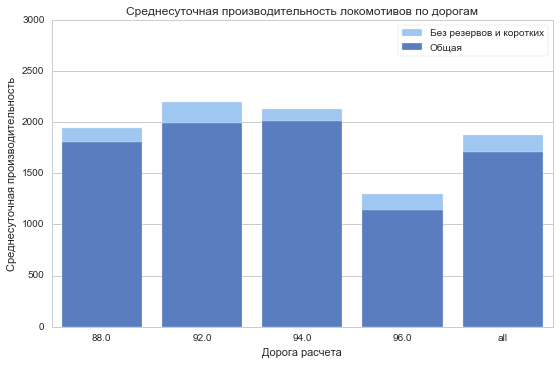

In [513]:
sns.set_color_codes("pastel")
fig = plt.figure()
sns.barplot(x='road', y='Без резервов и коротких', 
           data=e.ix[[i for i in e.index if i != 83.0]].reset_index(), 
           color="b", label='Без резервов и коротких')
sns.set_color_codes('muted')
ax = sns.barplot(x='road', y='Общая', 
                 data=e.ix[[i for i in e.index if i != 83.0]].reset_index(), 
                 color="b", label='Общая')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylim=(0, 3000), ylabel='Среднесуточная производительность', xlabel='Дорога расчета', 
       title='Среднесуточная производительность локомотивов по дорогам')
plt.legend(frameon=True, loc='best')
filename = FOLDER + 'loco_product.png'
plt.savefig(filename, bbox_inches='tight')
add_image(filename)

## Расчет пробега по группам локомотивов и по дорогам

In [514]:
add_header('Расчет пробега по группам локомотивов и по дорогам', h=2, p=False)

In [515]:
print('Среднесуточный полезный пробег локомотивов: %.2f км.' %
      (total_work_hor['dist_hor'].sum() / total_work_hor_n))
print('---------- без учета отставленных в резерв: %.2f км.' %
      (total_work_hor_expl['dist_hor'].sum() / total_work_hor_expl_n))
print('----------------------- без учета коротких: %.2f км.' %
      (total_work_hor_expl_long['dist_hor'].sum() / total_work_hor_expl_long_n))

Среднесуточный полезный пробег локомотивов: 452.06 км.
---------- без учета отставленных в резерв: 464.60 км.
----------------------- без учета коротких: 494.14 км.


In [516]:
a = count_by_road(total_work_hor, 'dist_hor')
b = count_by_road(total_work_hor_expl, 'dist_hor')
c = count_by_road(total_work_hor_expl_long, 'dist_hor')
d = a.to_frame().join(b.to_frame(), rsuffix='_expl')
e = d.join(c.to_frame(), rsuffix='_expl_long')
e.columns = ['Общий', 'Без резервов', 'Без резервов и коротких']
add_header('Среднесуточный пробег отдельно по дорогам:')
#add_line(e.reset_index())

1342 2
1277 2
1197 2
Среднесуточный пробег отдельно по дорогам:


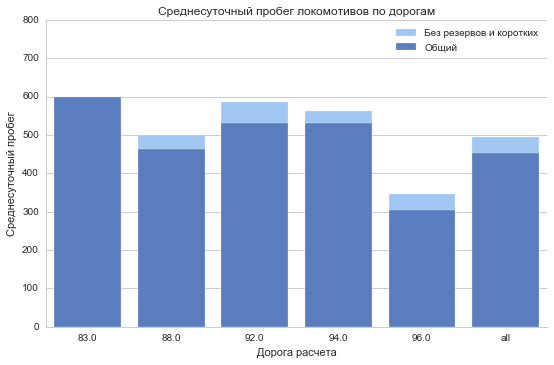

In [517]:
sns.set_color_codes("pastel")
fig = plt.figure()
sns.barplot(x='road', y='Без резервов и коротких', data=e.reset_index(), color="b", label='Без резервов и коротких')
sns.set_color_codes('muted')
ax = sns.barplot(x='road', y='Общий', data=e.reset_index(), color="b", label='Общий')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylim=(0, 800), ylabel='Среднесуточный пробег', xlabel='Дорога расчета', 
       title='Среднесуточный пробег локомотивов по дорогам')
sns.despine()
filename = FOLDER + 'loco_dist_total.png'
plt.savefig(filename, bbox_inches='tight')
add_image(filename)

## Расчет процента полезного использования по группам локомотивов

In [518]:
add_header('Расчет процента полезного использования по группам локомотивов', h=2, p=False)

In [520]:
# add_line('Среднесуточный процент полезного использования локомотивов: %.2f %%' %
#       (100 * total_work_hor['tt_hor'].sum() / (24 * 3600 * total_work_hor_n)))
# add_line('-------------------------- без учета отставленных в резерв: %.2f %%' %
#       (100 * total_work_hor_expl['tt_hor'].sum() / (24 * 3600 * total_work_hor_expl_n)))
# add_line('--------------------------------------- без учета коротких: %.2f %%' %
#       (100 * total_work_hor_expl_long['tt_hor'].sum() / (24 * 3600 * total_work_hor_expl_long_n)))

### Экспорт в HTML

In [522]:
filename = 'metrics_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 15))



NameError: name 'FOLDER' is not defined